In [1]:
import pandas as pd
import json
import glob
import re
import gzip

In [2]:
path = '/content/drive/MyDrive/Data challenges/Fetch rewards'

# read in data
datasets = dict()
for file in glob.glob(f'{path}/*.json.gz'):
    with gzip.open(file) as f:
        datasets[file] = pd.DataFrame(
            [json.loads(s) for s in f.read().decode().strip().split("\n") ] )

# to dataframes
df_brands = datasets[f'{path}/brands.json.gz']
df_receipts = datasets[f'{path}/receipts.json.gz']
df_users = datasets[f'{path}/users.json.gz']

In [3]:
df_receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      1119 non-null   object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               1119 non-null   object 
 4   dateScanned              1119 non-null   object 
 5   finishedDate             568 non-null    object 
 6   modifyDate               1119 non-null   object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    object 
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptItemList   679 non-null    object 
 12  rewardsReceiptStatus     1119 non-null   object 
 13  totalSpent               684 non-null    object 
 14  userId                  

In [4]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           495 non-null    object
 1   active        495 non-null    bool  
 2   createdDate   495 non-null    object
 3   lastLogin     433 non-null    object
 4   role          495 non-null    object
 5   signUpSource  447 non-null    object
 6   state         439 non-null    object
dtypes: bool(1), object(6)
memory usage: 23.8+ KB


In [5]:
df_brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           1167 non-null   object
 1   barcode       1167 non-null   object
 2   category      1012 non-null   object
 3   categoryCode  517 non-null    object
 4   cpg           1167 non-null   object
 5   name          1167 non-null   object
 6   topBrand      555 non-null    object
 7   brandCode     933 non-null    object
dtypes: object(8)
memory usage: 73.1+ KB


## Unnest ID fields and check for uniqueness

In [81]:
# extract IDs
get_oid = lambda x: x.get('$oid')
df_receipts['id'] = df_receipts['_id'].apply(get_oid)
df_users['id'] = df_users['_id'].apply(get_oid)
df_brands['id'] = df_brands['_id'].apply(get_oid)
df_brands['cpg_id'] = df_brands['cpg'].apply(lambda x: x.get('$id').get('$oid'))

# check for uniqueness
columns = [
    df_receipts['id'], 
    df_users['id'], 
    df_brands['id'], df_brands['cpg_id'], df_brands['barcode'], df_brands['brandCode']
]

for column in columns:
    print(column.name, len(column.dropna()) == len(column.dropna().unique()))

id True
id False
id True
cpg_id False
barcode False
brandCode False


Why is userId not unique? Rows appear to be whole duplicates of user record

In [87]:
vc_ids = df_users['id'].value_counts()
most_common_id = vc_ids.index[0]
df_users.loc[df_users['id'] == most_common_id].to_markdown()

"|     | _id                                  | active   | createdDate              | lastLogin                | role        |   signUpSource |   state | id                       |\n|----:|:-------------------------------------|:---------|:-------------------------|:-------------------------|:------------|---------------:|--------:|:-------------------------|\n| 475 | {'$oid': '54943462e4b07e684157a532'} | True     | {'$date': 1418998882381} | {'$date': 1614963143204} | fetch-staff |            nan |     nan | 54943462e4b07e684157a532 |\n| 476 | {'$oid': '54943462e4b07e684157a532'} | True     | {'$date': 1418998882381} | {'$date': 1614963143204} | fetch-staff |            nan |     nan | 54943462e4b07e684157a532 |\n| 477 | {'$oid': '54943462e4b07e684157a532'} | True     | {'$date': 1418998882381} | {'$date': 1614963143204} | fetch-staff |            nan |     nan | 54943462e4b07e684157a532 |\n| 478 | {'$oid': '54943462e4b07e684157a532'} | True     | {'$date': 1418998882381} | {'$date':

## `rewardsReceiptItemList` is a repeated field of json records. Let's explore its content and tie it back to the receipt ID

In [43]:
# how many receipts are missing this item list?
missing_item_lists = df_receipts.loc[df_receipts['rewardsReceiptItemList'].isnull()]
print(f'Missing {missing_item_lists.shape[0]} out of {len(df_receipts)}')

Missing 440 out of 1119


In [39]:
# They do not appear to have any spend totals
pd.to_numeric(missing_item_lists['totalSpent']).sum()

0.0

In [47]:
# They do not appear to be exclusive to a status
missing_item_lists['rewardsReceiptStatus'].value_counts()

SUBMITTED    434
REJECTED       3
FINISHED       2
PENDING        1
Name: rewardsReceiptStatus, dtype: int64

In [54]:
# create a new dataframe of the receipt items to understand its schema
receipt_items = df_receipts\
                    .dropna(subset=['rewardsReceiptItemList'])\
                    .explode('rewardsReceiptItemList')\
                    .reset_index(drop=True)\
                    .loc[:, ['id', 'rewardsReceiptItemList']]
records = receipt_items['rewardsReceiptItemList']\
            .apply(lambda x: {} if pd.isnull(x) else x)\
            .tolist()
items_frame = pd.DataFrame(records)
df_receiptItems = pd.concat([receipt_items, items_frame], axis=1).drop(columns=['rewardsReceiptItemList'])

In [55]:
df_receiptItems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6941 entries, 0 to 6940
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  6941 non-null   object 
 1   barcode                             3090 non-null   object 
 2   description                         6560 non-null   object 
 3   finalPrice                          6767 non-null   object 
 4   itemPrice                           6767 non-null   object 
 5   needsFetchReview                    813 non-null    object 
 6   partnerItemId                       6941 non-null   object 
 7   preventTargetGapPoints              358 non-null    object 
 8   quantityPurchased                   6767 non-null   float64
 9   userFlaggedBarcode                  337 non-null    object 
 10  userFlaggedNewItem                  323 non-null    object 
 11  userFlaggedPrice                    299 non

Above schema indicates that `partnerItemId` is the only non-null field found in a given receiptItem entity, but as a non-unique numeric field it does not appear to be a reliable foreign key

In [49]:
df_receiptItems['partnerItemId'].head()

0    1
1    1
2    2
3    1
4    1
Name: partnerItemId, dtype: object

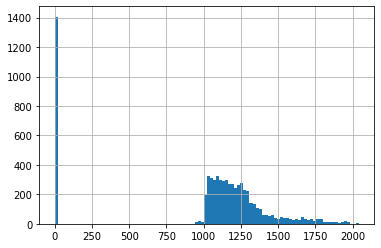

In [53]:
pd.to_numeric(df_receiptItems['partnerItemId']).hist(bins=100);

There are some possible foreign keys to the `brands` dataframe. Let's assess their viability

In [83]:
field_mapper = {
    'brandCode': ['brandCode', 'name'], 
    'barcode': ['barcode'], 
    'rewardsProductPartnerId': ['id', 'cpg_id'], 
    'pointsPayerId': ['id', 'cpg_id'],
    'partnerItemId': ['id', 'cpg_id', 'barcode', 'brandCode']
}

for receiptitem_field in field_mapper:
    receipt_valueset = set(df_receiptItems[receiptitem_field].values)
    for brand_field in field_mapper[receiptitem_field]:
        brand_valueset = set(df_brands[brand_field].values)
        match_rate = len(receipt_valueset & brand_valueset) / len(receipt_valueset)
        print(f"{100*round(match_rate, 2)}% of `brands.{brand_field}` matched in `receipts.{receiptitem_field}`")

18.0% of `brands.brandCode` matched in `receipts.brandCode`
1.0% of `brands.name` matched in `receipts.brandCode`
3.0% of `brands.barcode` matched in `receipts.barcode`
0.0% of `brands.id` matched in `receipts.rewardsProductPartnerId`
76.0% of `brands.cpg_id` matched in `receipts.rewardsProductPartnerId`
0.0% of `brands.id` matched in `receipts.pointsPayerId`
75.0% of `brands.cpg_id` matched in `receipts.pointsPayerId`
0.0% of `brands.id` matched in `receipts.partnerItemId`
0.0% of `brands.cpg_id` matched in `receipts.partnerItemId`
0.0% of `brands.barcode` matched in `receipts.partnerItemId`
0.0% of `brands.brandCode` matched in `receipts.partnerItemId`


Unfortunately, nothing matches to the `brand.id`. 

A receipt item's `rewardsProductPartnerId` or `pointsPayerId` have the highest observed match rates to the CPG ID from brands. However, a CPG seems to be a grouping of brands (i.e. a dimension to a brand), so it's not something we can tie back to specific brand.

This leaves us with the `brandCode` for matching receipts or receipt items to brands. This is not a good foreign key because:
1. It is just the name of the brand as recorded by the scanned receipt line item. 
2. There are a bunch of receipt line items missing brand codes.

In [80]:
df_brands['brandCode'].dropna().head()

1                        STARBUCKS
2    TEST BRANDCODE @1612366146176
3    TEST BRANDCODE @1612366146051
4    TEST BRANDCODE @1612366146827
5    TEST BRANDCODE @1612366146091
Name: brandCode, dtype: object

In [86]:
items_missing_brandcodes = df_receiptItems.brandCode.isnull().sum()
pct = 100* round(items_missing_brandcodes / len(df_receiptItems), 2)
print(f"{items_missing_brandcodes} receipt items are missing brand codes, {pct}% of items in the dataset.")

4341 receipt items are missing brand codes, 63.0% of items in the dataset.


Finally, the receiptItems schema indicates that there are multiple ways a receipt item metadata (e.g. description, barcode, price, quantity) can be logged (natively, user input,  Metabrite). Are these values coalesced into finalized metadata?